# Table of contents <a id='0.1'></a>

1. [Introduction](#1)
2. [Import Packages](#2)
3. [Data Overview](#3)
4. [Exploratory Data Analysis](#4)
    * 4.1 [Label Preprocessing](#4.1)
    * 4.2 [Exploring Image Data](#4.2)
    * 4.3 [Label Wise Cell Segmentation](#4.3)
5. [Refrence](#5)
6. [實驗筆記](#6)

# 2. <a id='2'>Import Packages📚</a>
[Table of contents](#0.1)

In [6]:
# basic 
import warnings
import re
import os, gc, cv2
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm

# visualize
import seaborn as sns
import matplotlib.pyplot as plt

# # segmentation tool
# import hpacellseg.cellsegmentator as cellsegmentator
# from hpacellseg.utils import label_cell, label_nuclei

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
import PIL
import torch
import torchvision

from torch.utils.data import Dataset, DataLoader
import cv2
from PIL import Image

import torchvision.models as models
import torch.nn as nn
from torch.nn import Linear, ReLU, CrossEntropyLoss, Conv2d, MaxPool2d, Module
from torch.optim import Adam
from ipywidgets import IntProgress

import json

Let us have a look at competiton data directory.

In [3]:
# directory
print('Competition Data/Files')
data_path = './data'
os.listdir(data_path)

Competition Data/Files


['5459_吟.jpg',
 '23786_承.jpg',
 '53155_里.jpg',
 '46841_儒.jpg',
 '44334_亞.jpg',
 '34679_登.jpg',
 '68141_航.jpg',
 '20629_顧.jpg',
 '38108_緯.jpg',
 '40797_承.jpg',
 '45263_消.jpg',
 '7277_信.jpg',
 '25299_哲.jpg',
 '16622_勤.jpg',
 '61451_油.jpg',
 '10706_事.jpg',
 '27632_亮.jpg',
 '30966_信.jpg',
 '18936_茂.jpg',
 '41233_徐.jpg',
 '53156_廠.jpg',
 '3786_人.jpg',
 '30231_屋.jpg',
 '9543_爾.jpg',
 '55018_智.jpg',
 '58581_同.jpg',
 '38896_碧.jpg',
 '41377_湯.jpg',
 '36140_蕭.jpg',
 '50211_蘇.jpg',
 '17553_代.jpg',
 '5414_鴻.jpg',
 '57448_生.jpg',
 '21849_雪.jpg',
 '15777_款.jpg',
 '19143_銘.jpg',
 '68425_事.jpg',
 '39640_詠.jpg',
 '34924_霖.jpg',
 '5973_歐.jpg',
 '18773_貨.jpg',
 '24403_琪.jpg',
 '47011_仲.jpg',
 '51974_潔.jpg',
 '52602_綺.jpg',
 '26306_晴.jpg',
 '11598_珠.jpg',
 '58815_南.jpg',
 '42781_昆.jpg',
 '28125_險.jpg',
 '7050_媛.jpg',
 '58416_發.jpg',
 '8547_連.jpg',
 '25140_人.jpg',
 '20482_慧.jpg',
 '24593_迪.jpg',
 '56069_員.jpg',
 '27760_威.jpg',
 '40794_集.jpg',
 '23443_冷.jpg',
 '32061_蕭.jpg',
 '234_館.jpg',
 '1449_逸.jpg',
 '2

# 3. <a id='3'>Data Overview📚</a>
[Table of contents](#0.1)

In [7]:
data_path = './data'
data_list = []
for filename in os.listdir(data_path):
    if filename.endswith(".jpg"):
        data_list.append(os.path.join(data_path, filename))


f = open("training data dic.txt", "r")
word_dict = {}
for word in f:
    word = word.replace('\n','')
    dict1 = {f'{word}': 0}
    word_dict.update(dict1)

pattern = r"_(\S).jpg"
for jpg_name in data_list:
    word = re.search(pattern, jpg_name).group(0).replace('_','').replace('.jpg','')
    word_dict[word] += 1

print(word_dict)

{'宋': 100, '名': 100, '楊': 100, '活': 100, '杜': 81, '輪': 100, '緯': 100, '詹': 100, '小': 100, '牙': 100, '歐': 100, '勤': 100, '聖': 100, '築': 100, '代': 100, '川': 100, '臻': 91, '地': 100, '德': 100, '連': 100, '千': 100, '海': 100, '蓁': 100, '限': 100, '貨': 100, '蕭': 100, '鑽': 26, '公': 100, '林': 100, '潔': 100, '詮': 72, '防': 100, '葳': 44, '化': 100, '房': 49, '涵': 98, '園': 100, '采': 100, '亮': 100, '漁': 63, '米': 100, '碩': 98, '兆': 100, '店': 100, '利': 100, '普': 100, '證': 100, '記': 100, '鴻': 100, '巨': 100, '幼': 100, '豪': 100, '基': 100, '宗': 100, '元': 100, '勳': 83, '御': 76, '薛': 67, '皓': 52, '佳': 100, '兒': 100, '好': 100, '翁': 100, '密': 100, '山': 100, '有': 100, '蔣': 45, '能': 100, '京': 100, '彩': 100, '吉': 100, '經': 100, '瑋': 100, '朱': 100, '團': 100, '藥': 100, '專': 100, '影': 100, '江': 100, '娟': 100, '龍': 100, '市': 100, '晟': 100, '整': 80, '捷': 100, '綠': 83, '湯': 74, '澤': 100, '悅': 100, '絲': 41, '包': 100, '煌': 100, '竹': 100, '道': 60, '展': 100, '通': 100, '眾': 67, '羅': 100, '護': 100, '聚': 79, '五': 100, '禎': 75, '

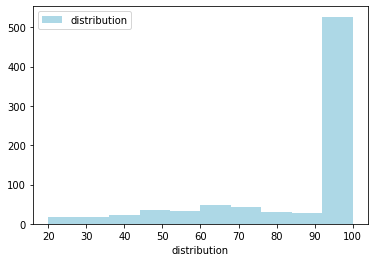

In [12]:
hist_distribution = []
for key in word_dict:
    hist_distribution.append(word_dict[key])

plt.hist(hist_distribution, density=False, color = 'lightblue', cumulative = False, label = "distribution")
plt.legend()
plt.xlabel('distribution')
plt.show()

In [11]:
hist_distribution = pd.DataFrame(hist_distribution, columns = ['frequency'])
desc = hist_distribution["frequency"].describe()
desc

count    800.000000
mean      86.005000
std       22.014672
min       20.000000
25%       73.000000
50%      100.000000
75%      100.000000
max      100.000000
Name: frequency, dtype: float64

# 4 <a id='4'>Exploratory Data Analysis🧬</a>
## 4.1 <a id=4.1>Preprocessing Labels</a>
[Table of contents](#0.1)

Since we are given multiple label in our **"Label"** column we need to binarize them so that each label/class will become a column.  

In [8]:
# spliting label column
train_df = pd.read_csv(os.path.join(ROOT, 'train.csv'))
# print(train_df["Label"])
# train_df["Label"] = train_df["Label"].str

# class labels
class_labels = ['0', '1', '2', '3', '4', '5']

# binarizing each label/class
for label in tqdm(class_labels):
#     print(type(label))
    train_df[label] = train_df['Label'].map(lambda result: 1 if int(label) == result else 0)


train_df

,ID,Label,0,1,2,3,4,5
0,train_00000.jpg,0,1,0,0,0,0,0
1,train_00001.jpg,1,0,1,0,0,0,0
2,train_00002.jpg,1,0,1,0,0,0,0
3,train_00003.jpg,5,0,0,0,0,0,1
4,train_00004.jpg,5,0,0,0,0,0,1
5,train_00005.jpg,5,0,0,0,0,0,1
6,train_00006.jpg,3,0,0,0,1,0,0
7,train_00007.jpg,0,1,0,0,0,0,0
8,train_00008.jpg,3,0,0,0,1,0,0
9,train_00009.jpg,5,0,0,0,0,0,1


In [9]:
class_counts = train_df.sum().drop(['ID', 'Label']).sort_values(ascending=False)

print('Per class count in train dataset')
print('-------------------------------------------------')
for column in class_counts.keys():
    print(f"The class {column} has {train_df[column].sum()} samples")

Per class count in train dataset
-------------------------------------------------
The class 0 has 1348 samples
The class 5 has 1288 samples
The class 1 has 984 samples
The class 3 has 756 samples
The class 4 has 480 samples
The class 2 has 200 samples


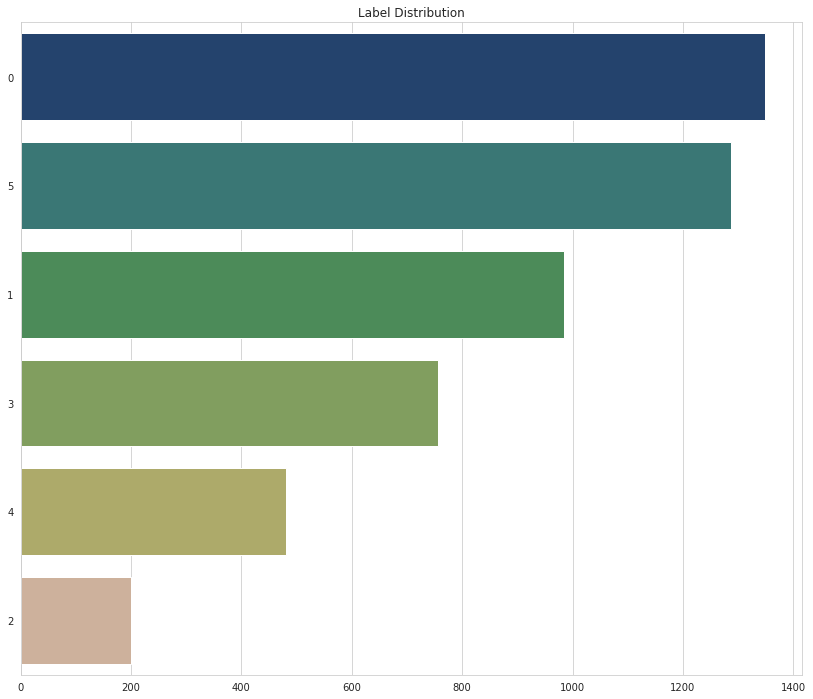

In [10]:
plt.figure(figsize=(14,12))
with sns.axes_style("whitegrid"):
    aa = sns.barplot(y=class_counts.index.values, x=class_counts.values, palette='gist_earth')
    plt.title("Label Distribution")

**📌 Observations**

   * training資料集中各分類的資料量數量分別是：**0 > 5 > 1 > 3 > 4 > 2**
   * 其中以下性質顯示此為imbalance data： 
       - Label 0 是 Label 3 的 2倍
       - Label 0 是 Label 4 的 3倍
       - Label 0 是 Label 2 的 6倍
                   

## 4.2 <a id=5.2>Exploring Image Data</a>
[Table of contents](#0.1)

Each sample consists of four image files. Each file represents a different filter on the subcellular protein patterns represented by the sample (ID).

* Red for Microtubule channels.
* Blue for Nuclei channels.
* Yellow for Endoplasmic Reticulum (ER) channels.
* Green for Protein of interest.

The "**Protein of interest**" (Green channel) is what we are prediciting for each sample with labels (multiple labels). This labels are the organelles. It is the pattern(s) in the green channel that we should classify. 

In [11]:
import random
def image_contrast(img):
    img = np.full(img.shape,255) - img
    img = 1.3 * img
    img[img > 255] = 255
    img = np.round(img)
    img = np.full(img.shape,255) - img
    img = img.astype(np.uint8)
    return img

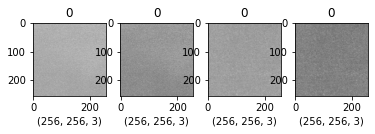

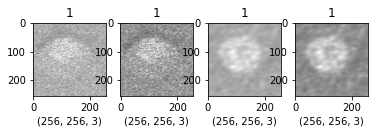

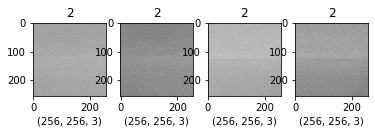

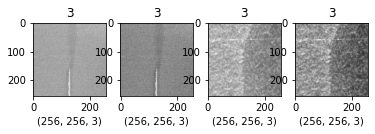

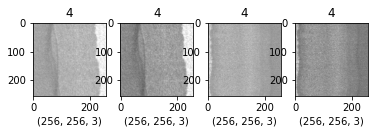

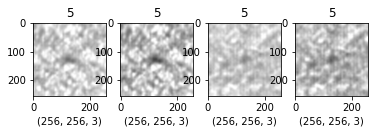

In [12]:

for iterate_ in range(6):
    pic_number = 1
    for index , picture in train_df.iterrows():
        if bool(random.getrandbits(1)):
            continue
        if picture['Label'] == iterate_:  
            img = cv2.imread(f'{ROOT}/train_images/{picture["ID"]}')
            plt.subplot(1,4,pic_number)
            plt.imshow(img)
            plt.title(f'{iterate_}')
            plt.xlabel(f'{img.shape}')
            pic_number += 1
            
            plt.subplot(1,4,pic_number)
            plt.imshow(image_contrast(img))
            plt.title(f'{iterate_}')
            plt.xlabel(f'{img.shape}')
            pic_number += 1
            
        if pic_number > 4:
            plt.show()
            break

# 5. <a id='5'>Start Training🧫</a>
## 5.1 <a id='5.1'>Wide Resnet 50</a>
[Table of contents](#0.1)


In [13]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

GPU State: cuda:0


In [14]:
# import os

# import numpy as np

# import PIL
# import torch
# import torchvision

# from tqdm import tqdm

# from torch.utils.data import Dataset, DataLoader
# import cv2
# from PIL import Image

# import torchvision.models as models
# import torch.nn as nn
# from torch.nn import Linear, ReLU, CrossEntropyLoss, Conv2d, MaxPool2d, Module
# from torch.optim import Adam
# from ipywidgets import IntProgress

# import json

class train:
    """
    intro:
        每次epoch都 train the model , validate the model
        並計算Early Stopping
        印出 train_loss , train_acc , val_loss , val_acc
        回傳 model
    aug:
        model,n_epochs,train_loader,valid_loader,optimizer,criterion,batch_size
    output:
        model
    """
    def __init__(self, model,name,n_epochs,train_loader,valid_loader,nb_classes,optimizer,scheduler,
                 criterion,batch_size,patience, resultFile , hyperparameter , decision_index = 'valid_loss'):
        self.model = model
        self.name = name
        self.n_epochs = n_epochs
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.nb_classes = nb_classes
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = criterion
        self.batch_size = batch_size
        self.patience = patience
        self.resultFile = resultFile
        self.hyperparameter = hyperparameter
        self.decision_index = decision_index
    
    def result_dir(self):
        result_file = f'{self.resultFile}/{self.name}'
        os.makedirs(result_file, exist_ok=True)
        return result_file
    
    def save_hyperparameter(self):
        hyperpara_address = f'{self.result_dir()}/hyperparameter.json'
        with open(f'{hyperpara_address}', 'w') as json_file:
            json.dump(self.hyperparameter, json_file)
    
    def __call__(self):
        print(f'Start to run {self.name}')
        history = history_record(self.model ,self.patience , self.result_dir() , self.hyperparameter)
        self.save_hyperparameter()
        
        self.model.cuda() if torch.cuda.is_available() else print('no gpu use')
        
        for epoch in range(1, self.n_epochs+1):
            # keep track of training and validation loss
            print(f'\nrunning epoch: {epoch}')
            train_loss , train_acc = self.train_stage()
            valid_loss , valid_acc , confusion_stacks = self.valid_stage()
            if self.scheduler:
                self.scheduler.step()
            print(f'Current learning rate: {optimizer.param_groups[0]["lr"]:.5f}')
            print(f'Training Loss: {train_loss:.3f} \tValidation Loss: {valid_loss:.3f}')
            print(f'Training Accuracy: {train_acc:.3f} \tValidation Accuracy: {valid_acc:.3f}')

            # evaluate
            precision , recall , f1 = self.confusion_matrix(confusion_stacks)

            # Early Stopping 
            save_record = {
                'train_accuracy':train_acc,
                'valid_accuracy':valid_acc,
                'train_loss':train_loss,
                'valid_loss':valid_loss,
                'precision':precision,
                'recall':recall,
                'f1':f1
            }
            early_stop = history.early_stop(self.model, save_record , self.decision_index )
            if early_stop:
                break
      
    
    
    def train_stage(self):
        train_correct,train_total=0,0
        self.model.train()
        train_losses = []
        for num, (data, target) in enumerate(self.train_loader):
            
            if torch.cuda.is_available():#train_on_gpu
                data, target = data.cuda(), target.cuda()
            
            #train for SAM optimizer
            def closure():
                self.optimizer.zero_grad()
                output = self.model(data)
                loss = self.criterion(output, target)
                loss.backward()
                return loss
            
            self.optimizer.step(closure)
            
            with torch.no_grad():
                output = self.model(data)
                loss = self.criterion(output, target)
            #calculate accuracy
            pred = output.data.max(dim = 1, keepdim = True)[1]
            train_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            train_total += data.size(0)
            # update training loss
            train_losses.append(loss.item()*data.size(0))


            if num%10 == 0 :
                print(f'{num}/{len(self.train_loader)}', end='\r')

        # calculate average losses
        train_loss=np.average(train_losses)
        # calculate average accuracy
        train_acc=train_correct/train_total

        return train_loss , train_acc
    
    def valid_stage(self):
        valid_losses = []
        confusion_stacks = []
        val_correct , val_total=0,0
        self.model.eval()
        for num, (data, target) in enumerate(self.valid_loader):

            if torch.cuda.is_available():#train_on_gpu
                data, target = data.cuda(), target.cuda()

            with torch.no_grad():
                output = self.model(data)
                loss = self.criterion(output, target)
            
            #calculate accuracy
            pred = output.data.max(dim = 1, keepdim = True)[1]
            val_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            val_total += data.size(0)
            # update validation loss
            valid_losses.append(loss.item()*data.size(0))
            
            if num%10 == 0 :
                print(f'{num}/{len(self.valid_loader)}', end='\r')

            #confusion matrix
            stacked = torch.stack((target,pred.t()[0]),dim=1)
            if num:
                confusion_stacks += stacked.cpu().detach().tolist()  
            else:
                confusion_stacks = stacked.cpu().detach().tolist()

        # calculate average losses
        valid_loss=np.average(valid_losses)
        # calculate average accuracy
        valid_acc=val_correct/val_total

        return valid_loss , valid_acc , confusion_stacks
    
    def confusion_matrix(self,confusion_stacks):
        cmt = torch.zeros(self.nb_classes,self.nb_classes, dtype=torch.int64)
        precision = np.array([])
        recall = np.array([])
        f1score = np.array([])
        for p in confusion_stacks:
            tl, pl = p
            cmt[tl, pl] = cmt[tl, pl] + 1
        
        # print out confusion matrix
        cmt_line = 'cmt\t'
        for a in range(self.nb_classes):
            cmt_line += f'pred:{a}\t'
        print(f'{cmt_line}')
        for label_class in range(self.nb_classes):
            cmt_line = f'label:{label_class}\t'
            for pred_class in range(self.nb_classes):
                cmt_line += f'{cmt[label_class,pred_class]}\t'
            print(f'{cmt_line}')
        print()
        for label_class in range(self.nb_classes):
            TP = cmt[label_class,label_class]
            precision_total = cmt[:,label_class].sum()
            recall_tatal = cmt[label_class,:].sum()

            p = np.float64(TP / precision_total) if precision_total != 0 else 0
            r = np.float64(TP / recall_tatal) if recall_tatal != 0 else 0
            F1 = np.float64(2 * r * p / (r + p)) if (r + p) != 0 else 0
            print(f'Label:{label_class}\tprec = {p:.3f}\trecall = {r:.3f}\tF1 = {F1:.3f}')
            
            precision = np.append(precision,p)
            recall = np.append(recall,r)
            f1score = np.append(f1score,F1)

        return np.mean(precision) , np.mean(recall) , np.mean(f1score)

class history_record:
    def __init__(self, model ,patience , address , hyperparameter):
        self.history = {
            'train_accuracy':[0],
            'valid_accuracy':[0],
            'train_loss':[100000],
            'valid_loss':[100000],
            'precision':[0],
            'recall':[0],
            'f1':[0]
        }
        self.last_epoch , self.best_epoch  = 0 , 0
        self.best_model = model
        self.trigger = 0
        self.patience = patience
        self.address = address
        self.hyperparameter = hyperparameter
    
    def __call__(self):
        return self.history , self.best_model
        
    
    def update(self , model , save_record, new_record = True):
        for item in ['train_accuracy' , 'valid_accuracy' , 'train_loss' , 'valid_loss' , 'precision' , 'recall' , 'f1']:
            self.history[item].append(save_record[item])
        self.last_epoch += 1
        
        if new_record:
            self.best_epoch = self.last_epoch
            self.best_model = model 
            self.trigger = 0
    
    def save_json(self, save_record):
        record_address = f'{self.address}/record.json'
        with open(f'{record_address}', 'w') as json_file:
            json.dump(save_record, json_file)
            
    def save_model(self):
        model_address = f'{self.address}/model.pt'
        torch.save(self.best_model, model_address)
    
        
    def early_stop(self ,model, save_record , decision_index , setEarly_stop = True):
        if setEarly_stop:
            best_decision_record = self.history[decision_index][self.best_epoch]

            if decision_index is 'train_loss' or decision_index is 'valid_loss':
                new_record = True if best_decision_record > save_record[decision_index] else False
            else:
                new_record = True if best_decision_record < save_record[decision_index] else False
    #         print(f'best_decision_record:{best_decision_record:.3f}\tsave_record:{save_record[decision_index]:.3f}')
    #         print(f'new_record:{new_record}')

            self.update(model , save_record, new_record)
            if not new_record:
                self.trigger += 1
                print(f'trigger times: {self.trigger}\n')
                if self.trigger > self.patience:                
                    print(f'Early stopping at trigger times: {self.trigger}')
                    for item in ['train_accuracy' , 'valid_accuracy' , 'train_loss' , 'valid_loss' , 'precision' , 'recall' , 'f1']:
                        print(f'Best {item}: {self.history[item][self.best_epoch]:.3f}')

                    return True
            else:
                self.save_json(save_record)
                self.save_model()

            return False
        
        else :
            self.update(model , save_record, new_record = True)
            self.save_json(save_record)
            self.save_model()
            return False
            

In [15]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)

if '../../module/' not in sys.path:
    sys.path.insert(0, '../../module/')
    print('add')
# import CNN_training_classification_module
# from CNN_training_classification_module import train , history_record

# sys.path.insert(0, '../../module/focal_loss_pytorch/')
print(sys.path)


from focal_loss_pytorch.focalloss import FocalLoss
from SAM.sam import SAMSGD

# import importlib
criterion = FocalLoss(gamma = 2)

# criterion = nn.CrossEntropyLoss()

add
['../../module/', '/opt/conda/lib/python36.zip', '/opt/conda/lib/python3.6', '/opt/conda/lib/python3.6/lib-dynload', '', '/home/u7085556/.local/lib/python3.6/site-packages', '/opt/conda/lib/python3.6/site-packages', '/opt/conda/lib/python3.6/site-packages/IPython/extensions', '/home/u7085556/.ipython']


In [16]:
class Dataset(Dataset):
    def __init__(self, x, y , transform):
        self.x = x
        self.y = y
        self.transform = transform
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        img_address = f'./dataset/train_images/{self.x[idx]}'
        img = cv2.imread(img_address, cv2.IMREAD_COLOR)
        if img is None:
            print('Not found img : ', self.x[idx])
            print(self.x[idx])
        img = image_contrast(img)
        img = Image.fromarray(img)
        img = self.transform(img)
        return img, self.y[idx]

In [17]:
from torch import randperm

def random_split_train_valid_data(path , label , scale):
    
    indices = randperm(len(path)).tolist()
    
    train_size = int(scale * len(path))
    print(f'train_size:{train_size}\tvalid_size:{len(path)-train_size}')
    path_train = []
    label_train = []
    for index in indices[:train_size]:
        path_train.append(path[index])
        label_train.append(label[index])
    
    path_valid = []
    label_valid = []
    for index in indices[train_size:]:
        path_valid.append(path[index])
        label_valid.append(label[index])
    
    
    return path_train , label_train , path_valid , label_valid


In [18]:
def dataloader_prepare(ROOT='./dataset', batch_size = 128 , inputshape = 224):
    """
    aug:
        folder = 讀入資料之目的資料夾
        batch_size = batch_size
    output:
        train_dataloader, valid_dataloader
    """    
    transform_preprocess = { 
        "train": torchvision.transforms.Compose([
            #torchvision.transforms.Resize(inputshape),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomVerticalFlip(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ]),
        "valid": torchvision.transforms.Compose([
            #torchvision.transforms.Resize(inputshape),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomVerticalFlip(),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
    }
    
    train_df = pd.read_csv(os.path.join(ROOT, 'train.csv'))
    path, label = train_df['ID'] , train_df['Label']
    
    #random split two array
    #切分80%當作訓練集、20%當作驗證集
    train_scale = 0.8
    path_train , label_train , path_valid , label_valid = random_split_train_valid_data(path , label , train_scale)
    
    train_dataset = Dataset(path_train, label_train ,transform_preprocess['train'])
    valid_dataset = Dataset(path_valid, label_valid ,transform_preprocess['valid'])
    
    train_dataloader = DataLoader( train_dataset , batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader( valid_dataset , batch_size=batch_size, shuffle=True)
    
    return train_dataloader, valid_dataloader

# model select

In [19]:
# hyper parameter

nb_classes = 6
batchsizes = 64
n_epochs = 2000
patience = 100

inputshape = 240

learning_rate = 0.001
weight_decay = 0.005
momentum = 0.9
T_max = 20

name = 'EfficientNet_B3_SAM_SGDR_contrast_1.3_trylargeepoch'

In [20]:


# model_ft_wide_resnet50_2 = models.wide_resnet50_2(pretrained=True)
# num_ftrs = model_ft_wide_resnet50_2.fc.in_features
# model_ft_wide_resnet50_2.fc = nn.Linear(num_ftrs,nb_classes)
# model_ft_wide_resnet50_2=model_ft_wide_resnet50_2.to(device)# 放入裝置

# # for param in list(model_ft_wide_resnet50_2.parameters())[:-24]:
# #     param.requires_grad = False

# model_ft = model_ft_wide_resnet50_2

#############################

# model_ft_vgg16 = models.vgg16(pretrained=True)
# num_ftrs = model_ft_vgg16.classifier[6].in_features
# model_ft_vgg16.classifier[6] = nn.Linear(num_ftrs,nb_classes)
# model_ft_vgg16=model_ft_vgg16.to(device)# 放入裝置


#############################

from efficientnet_pytorch import EfficientNet
from torch import nn
model_ft = EfficientNet.from_pretrained('efficientnet-b3', num_classes = nb_classes)




Loaded pretrained weights for efficientnet-b3


In [21]:
# optimizer = torch.optim.Adam(model_ft.parameters(), lr=learning_rate, weight_decay=weight_decay)
# optimizer = torch.optim.SGD(model_ft.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)
# optimizer = torch.optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=momentum)
optimizer = SAMSGD(model_ft.parameters(), lr=learning_rate , momentum=momentum)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = T_max)
# scheduler = None

train_loader, valid_loader = dataloader_prepare(ROOT='./dataset', batch_size = batchsizes , inputshape = inputshape)



hyperparameter = {
    'model' : name,
    'n_epochs' : n_epochs,
    'optimizer' : 'SAM_cosine annealing schedule',
    'criterion' : 'FocalLoss gamma = 2',
    'batch_size' : batchsizes
}

train_size:4044	valid_size:1012


In [22]:
train_for_AIO = train(
        model = model_ft,
        name = name,
        n_epochs = n_epochs,
        train_loader = train_loader,
        valid_loader = valid_loader,
        nb_classes = nb_classes,
        optimizer = optimizer,
        scheduler = scheduler,
        criterion = criterion,
        batch_size = batchsizes,
        patience = patience,
        hyperparameter = hyperparameter,
        resultFile = './result'
    )

In [23]:
train_for_AIO()

Start to run EfficientNet_B3_SAM_SGDR_contrast_1.3_trylargeepoch

running epoch: 1
Current learning rate: 0.00099
Training Loss: 53.286 	Validation Loss: 44.418
Training Accuracy: 0.587 	Validation Accuracy: 0.736
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	271	16	0	0	2	1	
label:1	71	101	1	3	0	17	
label:2	44	0	1	3	1	0	
label:3	47	1	7	91	10	0	
label:4	27	1	1	12	47	0	
label:5	0	1	0	1	0	234	

Label:0	prec = 0.589	recall = 0.934	F1 = 0.723
Label:1	prec = 0.842	recall = 0.523	F1 = 0.645
Label:2	prec = 0.100	recall = 0.020	F1 = 0.034
Label:3	prec = 0.827	recall = 0.583	F1 = 0.684
Label:4	prec = 0.783	recall = 0.534	F1 = 0.635
Label:5	prec = 0.929	recall = 0.992	F1 = 0.959

running epoch: 2
Current learning rate: 0.00098
Training Loss: 27.159 	Validation Loss: 23.532
Training Accuracy: 0.823 	Validation Accuracy: 0.877
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	268	21	0	0	1	0	
label:1	12	170	0	4	1	6	
label:2	29	0	16	4	0	0	
label:3	9	10	0	135	2	0	
label:4	2	1	0	20	65	0	


Current learning rate: 0.00015
Training Loss: 5.353 	Validation Loss: 4.245
Training Accuracy: 0.952 	Validation Accuracy: 0.964
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	287	2	1	0	0	0	
label:1	8	180	0	3	1	1	
label:2	1	0	48	0	0	0	
label:3	2	7	0	145	2	0	
label:4	0	2	0	5	81	0	
label:5	0	1	0	0	0	235	

Label:0	prec = 0.963	recall = 0.990	F1 = 0.976
Label:1	prec = 0.938	recall = 0.933	F1 = 0.935
Label:2	prec = 0.980	recall = 0.980	F1 = 0.980
Label:3	prec = 0.948	recall = 0.929	F1 = 0.939
Label:4	prec = 0.964	recall = 0.920	F1 = 0.942
Label:5	prec = 0.996	recall = 0.996	F1 = 0.996

running epoch: 16
Current learning rate: 0.00010
Training Loss: 5.511 	Validation Loss: 4.156
Training Accuracy: 0.948 	Validation Accuracy: 0.964
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	10	179	0	3	0	1	
label:2	4	0	45	0	0	0	
label:3	2	7	0	144	3	0	
label:4	0	1	0	4	83	0	
label:5	0	1	0	0	0	235	

Label:0	prec = 0.948	recall = 1.000	F1 = 0.973
Label:1	prec = 0.952	reca

Current learning rate: 0.00042
Training Loss: 4.702 	Validation Loss: 3.600
Training Accuracy: 0.955 	Validation Accuracy: 0.971
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	289	0	1	0	0	0	
label:1	8	181	0	1	2	1	
label:2	1	0	48	0	0	0	
label:3	1	7	0	147	1	0	
label:4	0	1	0	4	83	0	
label:5	0	1	0	0	0	235	

Label:0	prec = 0.967	recall = 0.997	F1 = 0.981
Label:1	prec = 0.953	recall = 0.938	F1 = 0.945
Label:2	prec = 0.980	recall = 0.980	F1 = 0.980
Label:3	prec = 0.967	recall = 0.942	F1 = 0.955
Label:4	prec = 0.965	recall = 0.943	F1 = 0.954
Label:5	prec = 0.996	recall = 0.996	F1 = 0.996

running epoch: 30
Current learning rate: 0.00050
Training Loss: 4.707 	Validation Loss: 3.510
Training Accuracy: 0.951 	Validation Accuracy: 0.970
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	288	1	1	0	0	0	
label:1	9	181	0	1	1	1	
label:2	3	0	46	0	0	0	
label:3	1	7	0	147	1	0	
label:4	0	1	0	2	85	0	
label:5	0	1	0	0	0	235	

Label:0	prec = 0.957	recall = 0.993	F1 = 0.975
Label:1	prec = 0.948	recal

Current learning rate: 0.00095
Training Loss: 2.405 	Validation Loss: 1.908
Training Accuracy: 0.974 	Validation Accuracy: 0.981
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	3	185	0	2	2	1	
label:2	1	0	48	0	0	0	
label:3	0	5	0	149	2	0	
label:4	0	1	0	1	86	0	
label:5	0	1	0	0	0	235	

Label:0	prec = 0.986	recall = 1.000	F1 = 0.993
Label:1	prec = 0.964	recall = 0.959	F1 = 0.961
Label:2	prec = 1.000	recall = 0.980	F1 = 0.990
Label:3	prec = 0.980	recall = 0.955	F1 = 0.968
Label:4	prec = 0.956	recall = 0.977	F1 = 0.966
Label:5	prec = 0.996	recall = 0.996	F1 = 0.996
trigger times: 1


running epoch: 44
Current learning rate: 0.00090
Training Loss: 2.156 	Validation Loss: 1.791
Training Accuracy: 0.980 	Validation Accuracy: 0.984
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	2	188	0	1	1	1	
label:2	1	0	48	0	0	0	
label:3	1	6	0	149	0	0	
label:4	0	1	0	1	86	0	
label:5	0	1	0	0	0	235	

Label:0	prec = 0.986	recall = 1.000	F1 = 0.993
Label:1	

Current learning rate: 0.00005
Training Loss: 1.655 	Validation Loss: 1.353
Training Accuracy: 0.984 	Validation Accuracy: 0.987
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	289	0	1	0	0	0	
label:1	2	189	0	0	1	1	
label:2	0	0	49	0	0	0	
label:3	1	5	0	150	0	0	
label:4	0	1	0	0	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 0.990	recall = 0.997	F1 = 0.993
Label:1	prec = 0.969	recall = 0.979	F1 = 0.974
Label:2	prec = 0.980	recall = 1.000	F1 = 0.990
Label:3	prec = 0.993	recall = 0.962	F1 = 0.977
Label:4	prec = 0.989	recall = 0.989	F1 = 0.989
Label:5	prec = 0.996	recall = 0.996	F1 = 0.996
trigger times: 6


running epoch: 58
Current learning rate: 0.00002
Training Loss: 2.063 	Validation Loss: 1.458
Training Accuracy: 0.975 	Validation Accuracy: 0.984
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	289	0	1	0	0	0	
label:1	1	189	0	1	1	1	
label:2	0	0	49	0	0	0	
label:3	1	5	0	149	1	0	
label:4	0	1	0	2	85	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 0.993	recall = 0.997	F1 = 0.995
Label:1	

Current learning rate: 0.00058
Training Loss: 1.741 	Validation Loss: 1.237
Training Accuracy: 0.983 	Validation Accuracy: 0.989
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	191	0	1	0	1	
label:2	0	0	49	0	0	0	
label:3	0	6	0	150	0	0	
label:4	0	0	0	2	86	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1	prec = 0.970	recall = 0.990	F1 = 0.979
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 0.974	recall = 0.962	F1 = 0.968
Label:4	prec = 1.000	recall = 0.977	F1 = 0.989
Label:5	prec = 0.996	recall = 0.996	F1 = 0.996
trigger times: 2


running epoch: 72
Current learning rate: 0.00065
Training Loss: 1.648 	Validation Loss: 1.208
Training Accuracy: 0.982 	Validation Accuracy: 0.985
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	3	187	0	1	1	1	
label:2	0	0	49	0	0	0	
label:3	0	5	0	150	1	0	
label:4	0	1	0	1	86	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 0.990	recall = 1.000	F1 = 0.995
Label:1	

Current learning rate: 0.00085
Training Loss: 1.089 	Validation Loss: 0.972
Training Accuracy: 0.989 	Validation Accuracy: 0.991
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	1	189	0	1	1	1	
label:2	0	0	49	0	0	0	
label:3	0	3	0	153	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 0.997	recall = 1.000	F1 = 0.998
Label:1	prec = 0.984	recall = 0.979	F1 = 0.982
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 0.981	recall = 0.981	F1 = 0.981
Label:4	prec = 0.989	recall = 0.989	F1 = 0.989
Label:5	prec = 0.996	recall = 0.996	F1 = 0.996
trigger times: 3


running epoch: 86
Current learning rate: 0.00079
Training Loss: 1.076 	Validation Loss: 1.068
Training Accuracy: 0.990 	Validation Accuracy: 0.988
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	1	188	0	2	1	1	
label:2	0	0	49	0	0	0	
label:3	0	4	0	152	0	0	
label:4	0	1	0	1	86	0	
label:5	0	1	0	0	0	235	

Label:0	prec = 0.997	recall = 1.000	F1 = 0.998
Label:1	

Current learning rate: 0.00001
Training Loss: 1.067 	Validation Loss: 0.816
Training Accuracy: 0.989 	Validation Accuracy: 0.990
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	191	0	1	0	1	
label:2	0	0	49	0	0	0	
label:3	0	6	0	150	0	0	
label:4	0	0	0	1	87	0	
label:5	0	1	0	0	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1	prec = 0.965	recall = 0.990	F1 = 0.977
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 0.987	recall = 0.962	F1 = 0.974
Label:4	prec = 1.000	recall = 0.989	F1 = 0.994
Label:5	prec = 0.996	recall = 0.996	F1 = 0.996
trigger times: 1


running epoch: 100
Current learning rate: 0.00000
Training Loss: 0.988 	Validation Loss: 0.880
Training Accuracy: 0.990 	Validation Accuracy: 0.992
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	191	0	1	0	1	
label:2	0	0	49	0	0	0	
label:3	0	3	0	153	0	0	
label:4	0	0	0	2	86	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1

Current learning rate: 0.00065
Training Loss: 0.878 	Validation Loss: 0.857
Training Accuracy: 0.990 	Validation Accuracy: 0.990
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	289	0	1	0	0	0	
label:1	1	190	0	1	1	0	
label:2	0	0	49	0	0	0	
label:3	0	3	0	153	0	0	
label:4	0	0	0	2	86	0	
label:5	0	1	0	0	0	235	

Label:0	prec = 0.997	recall = 0.997	F1 = 0.997
Label:1	prec = 0.979	recall = 0.984	F1 = 0.982
Label:2	prec = 0.980	recall = 1.000	F1 = 0.990
Label:3	prec = 0.981	recall = 0.981	F1 = 0.981
Label:4	prec = 0.989	recall = 0.977	F1 = 0.983
Label:5	prec = 1.000	recall = 0.996	F1 = 0.998
trigger times: 14


running epoch: 113
Current learning rate: 0.00073
Training Loss: 1.012 	Validation Loss: 0.846
Training Accuracy: 0.990 	Validation Accuracy: 0.992
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	1	191	0	1	0	0	
label:2	0	0	49	0	0	0	
label:3	0	3	0	153	0	0	
label:4	0	0	0	2	86	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 0.997	recall = 1.000	F1 = 0.998
Label:

Current learning rate: 0.00079
Training Loss: 0.725 	Validation Loss: 0.719
Training Accuracy: 0.993 	Validation Accuracy: 0.992
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	1	189	0	2	1	0	
label:2	0	0	49	0	0	0	
label:3	0	2	0	154	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 0.997	recall = 1.000	F1 = 0.998
Label:1	prec = 0.990	recall = 0.979	F1 = 0.984
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 0.975	recall = 0.987	F1 = 0.981
Label:4	prec = 0.989	recall = 0.989	F1 = 0.989
Label:5	prec = 1.000	recall = 0.996	F1 = 0.998
trigger times: 1


running epoch: 127
Current learning rate: 0.00073
Training Loss: 0.669 	Validation Loss: 0.736
Training Accuracy: 0.994 	Validation Accuracy: 0.992
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	1	189	0	1	1	1	
label:2	0	0	49	0	0	0	
label:3	0	2	0	154	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 0.997	recall = 1.000	F1 = 0.998
Label:1

Current learning rate: 0.00001
Training Loss: 0.629 	Validation Loss: 0.737
Training Accuracy: 0.994 	Validation Accuracy: 0.994
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	1	191	0	1	0	0	
label:2	0	0	49	0	0	0	
label:3	0	2	0	154	0	0	
label:4	0	1	0	0	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 0.997	recall = 1.000	F1 = 0.998
Label:1	prec = 0.985	recall = 0.990	F1 = 0.987
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 0.987	recall = 0.987	F1 = 0.987
Label:4	prec = 1.000	recall = 0.989	F1 = 0.994
Label:5	prec = 1.000	recall = 0.996	F1 = 0.998
trigger times: 11


running epoch: 140
Current learning rate: 0.00000
Training Loss: 0.611 	Validation Loss: 0.643
Training Accuracy: 0.995 	Validation Accuracy: 0.996
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	192	0	1	0	0	
label:2	0	0	49	0	0	0	
label:3	0	1	0	155	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:

Current learning rate: 0.00065
Training Loss: 0.619 	Validation Loss: 0.698
Training Accuracy: 0.996 	Validation Accuracy: 0.993
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	1	190	0	1	0	1	
label:2	0	0	49	0	0	0	
label:3	0	2	0	154	0	0	
label:4	0	0	0	1	87	0	
label:5	0	1	0	0	0	235	

Label:0	prec = 0.997	recall = 1.000	F1 = 0.998
Label:1	prec = 0.984	recall = 0.984	F1 = 0.984
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 0.987	recall = 0.987	F1 = 0.987
Label:4	prec = 1.000	recall = 0.989	F1 = 0.994
Label:5	prec = 0.996	recall = 0.996	F1 = 0.996
trigger times: 11


running epoch: 153
Current learning rate: 0.00073
Training Loss: 0.607 	Validation Loss: 0.707
Training Accuracy: 0.993 	Validation Accuracy: 0.995
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	1	191	0	1	0	0	
label:2	0	0	49	0	0	0	
label:3	0	1	0	155	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 0.997	recall = 1.000	F1 = 0.998
Label:

Current learning rate: 0.00085
Training Loss: 0.497 	Validation Loss: 0.688
Training Accuracy: 0.995 	Validation Accuracy: 0.992
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	1	191	0	0	0	1	
label:2	0	0	49	0	0	0	
label:3	0	4	0	152	0	0	
label:4	0	1	0	0	87	0	
label:5	0	1	0	0	0	235	

Label:0	prec = 0.997	recall = 1.000	F1 = 0.998
Label:1	prec = 0.970	recall = 0.990	F1 = 0.979
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 1.000	recall = 0.974	F1 = 0.987
Label:4	prec = 1.000	recall = 0.989	F1 = 0.994
Label:5	prec = 0.996	recall = 0.996	F1 = 0.996
trigger times: 24


running epoch: 166
Current learning rate: 0.00079
Training Loss: 0.661 	Validation Loss: 0.665
Training Accuracy: 0.992 	Validation Accuracy: 0.992
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	1	190	0	1	1	0	
label:2	0	0	49	0	0	0	
label:3	0	3	0	153	0	0	
label:4	0	0	0	1	87	0	
label:5	0	1	0	0	0	235	

Label:0	prec = 0.997	recall = 1.000	F1 = 0.998
Label:

Current learning rate: 0.00002
Training Loss: 0.472 	Validation Loss: 0.636
Training Accuracy: 0.996 	Validation Accuracy: 0.995
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	1	191	0	1	0	0	
label:2	0	0	49	0	0	0	
label:3	0	1	0	155	0	0	
label:4	0	0	0	1	87	0	
label:5	0	1	0	0	0	235	

Label:0	prec = 0.997	recall = 1.000	F1 = 0.998
Label:1	prec = 0.990	recall = 0.990	F1 = 0.990
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 0.987	recall = 0.994	F1 = 0.990
Label:4	prec = 1.000	recall = 0.989	F1 = 0.994
Label:5	prec = 1.000	recall = 0.996	F1 = 0.998
trigger times: 2


running epoch: 179
Current learning rate: 0.00001
Training Loss: 0.410 	Validation Loss: 0.679
Training Accuracy: 0.996 	Validation Accuracy: 0.996
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	193	0	0	0	0	
label:2	0	0	49	0	0	0	
label:3	0	2	0	154	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1

Current learning rate: 0.00058
Training Loss: 0.475 	Validation Loss: 0.594
Training Accuracy: 0.994 	Validation Accuracy: 0.997
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	193	0	0	0	0	
label:2	0	0	49	0	0	0	
label:3	0	1	0	155	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1	prec = 0.995	recall = 1.000	F1 = 0.997
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 0.987	recall = 0.994	F1 = 0.990
Label:4	prec = 1.000	recall = 0.989	F1 = 0.994
Label:5	prec = 1.000	recall = 0.996	F1 = 0.998
trigger times: 1


running epoch: 192
Current learning rate: 0.00065
Training Loss: 0.445 	Validation Loss: 0.582
Training Accuracy: 0.995 	Validation Accuracy: 0.996
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	191	0	1	1	0	
label:2	0	0	49	0	0	0	
label:3	0	0	0	156	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1

Current learning rate: 0.00090
Training Loss: 0.381 	Validation Loss: 0.546
Training Accuracy: 0.997 	Validation Accuracy: 0.995
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	192	0	0	1	0	
label:2	0	0	49	0	0	0	
label:3	0	2	0	154	0	0	
label:4	0	0	0	1	87	0	
label:5	0	1	0	0	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1	prec = 0.985	recall = 0.995	F1 = 0.990
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 0.994	recall = 0.987	F1 = 0.990
Label:4	prec = 0.989	recall = 0.989	F1 = 0.989
Label:5	prec = 1.000	recall = 0.996	F1 = 0.998
trigger times: 11


running epoch: 205
Current learning rate: 0.00085
Training Loss: 0.296 	Validation Loss: 0.577
Training Accuracy: 0.998 	Validation Accuracy: 0.996
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	1	192	0	0	0	0	
label:2	0	0	49	0	0	0	
label:3	0	1	0	155	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 0.997	recall = 1.000	F1 = 0.998
Label:

Current learning rate: 0.00002
Training Loss: 0.296 	Validation Loss: 0.610
Training Accuracy: 0.996 	Validation Accuracy: 0.994
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	1	190	0	0	1	1	
label:2	0	0	49	0	0	0	
label:3	0	1	0	155	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 0.997	recall = 1.000	F1 = 0.998
Label:1	prec = 0.995	recall = 0.984	F1 = 0.990
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 0.987	recall = 0.994	F1 = 0.990
Label:4	prec = 0.989	recall = 0.989	F1 = 0.989
Label:5	prec = 0.996	recall = 0.996	F1 = 0.996
trigger times: 3


running epoch: 219
Current learning rate: 0.00001
Training Loss: 0.400 	Validation Loss: 0.601
Training Accuracy: 0.996 	Validation Accuracy: 0.997
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	192	0	1	0	0	
label:2	0	0	49	0	0	0	
label:3	0	0	0	156	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1

Current learning rate: 0.00058
Training Loss: 0.357 	Validation Loss: 0.514
Training Accuracy: 0.996 	Validation Accuracy: 0.996
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	192	0	1	0	0	
label:2	0	0	49	0	0	0	
label:3	0	1	0	155	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1	prec = 0.995	recall = 0.995	F1 = 0.995
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 0.981	recall = 0.994	F1 = 0.987
Label:4	prec = 1.000	recall = 0.989	F1 = 0.994
Label:5	prec = 1.000	recall = 0.996	F1 = 0.998
trigger times: 6


running epoch: 232
Current learning rate: 0.00065
Training Loss: 0.378 	Validation Loss: 0.590
Training Accuracy: 0.996 	Validation Accuracy: 0.993
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	1	188	0	2	1	1	
label:2	0	0	49	0	0	0	
label:3	0	0	0	156	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 0.997	recall = 1.000	F1 = 0.998
Label:1

Current learning rate: 0.00090
Training Loss: 0.301 	Validation Loss: 0.584
Training Accuracy: 0.998 	Validation Accuracy: 0.995
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	191	0	1	0	1	
label:2	0	0	49	0	0	0	
label:3	0	1	0	155	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1	prec = 0.995	recall = 0.990	F1 = 0.992
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 0.981	recall = 0.994	F1 = 0.987
Label:4	prec = 1.000	recall = 0.989	F1 = 0.994
Label:5	prec = 0.996	recall = 0.996	F1 = 0.996
trigger times: 19


running epoch: 245
Current learning rate: 0.00085
Training Loss: 0.246 	Validation Loss: 0.552
Training Accuracy: 0.998 	Validation Accuracy: 0.996
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	1	192	0	0	0	0	
label:2	0	0	49	0	0	0	
label:3	0	1	0	155	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 0.997	recall = 1.000	F1 = 0.998
Label:

Current learning rate: 0.00005
Training Loss: 0.324 	Validation Loss: 0.500
Training Accuracy: 0.998 	Validation Accuracy: 0.997
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	193	0	0	0	0	
label:2	0	0	49	0	0	0	
label:3	0	1	0	155	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1	prec = 0.995	recall = 1.000	F1 = 0.997
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 0.987	recall = 0.994	F1 = 0.990
Label:4	prec = 1.000	recall = 0.989	F1 = 0.994
Label:5	prec = 1.000	recall = 0.996	F1 = 0.998
trigger times: 5


running epoch: 258
Current learning rate: 0.00002
Training Loss: 0.285 	Validation Loss: 0.544
Training Accuracy: 0.998 	Validation Accuracy: 0.994
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	1	190	0	1	1	0	
label:2	0	0	49	0	0	0	
label:3	0	1	0	155	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 0.997	recall = 1.000	F1 = 0.998
Label:1

Current learning rate: 0.00050
Training Loss: 0.242 	Validation Loss: 0.520
Training Accuracy: 0.999 	Validation Accuracy: 0.994
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	1	189	0	1	1	1	
label:2	0	0	49	0	0	0	
label:3	0	0	0	156	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 0.997	recall = 1.000	F1 = 0.998
Label:1	prec = 1.000	recall = 0.979	F1 = 0.990
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 0.981	recall = 1.000	F1 = 0.990
Label:4	prec = 0.989	recall = 0.989	F1 = 0.989
Label:5	prec = 0.996	recall = 0.996	F1 = 0.996
trigger times: 1


running epoch: 271
Current learning rate: 0.00058
Training Loss: 0.242 	Validation Loss: 0.543
Training Accuracy: 0.998 	Validation Accuracy: 0.996
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	192	0	1	0	0	
label:2	0	0	49	0	0	0	
label:3	0	1	0	155	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1

Current learning rate: 0.00095
Training Loss: 0.292 	Validation Loss: 0.546
Training Accuracy: 0.997 	Validation Accuracy: 0.997
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	193	0	0	0	0	
label:2	0	0	49	0	0	0	
label:3	0	1	0	155	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1	prec = 0.995	recall = 1.000	F1 = 0.997
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 0.987	recall = 0.994	F1 = 0.990
Label:4	prec = 1.000	recall = 0.989	F1 = 0.994
Label:5	prec = 1.000	recall = 0.996	F1 = 0.998
trigger times: 1


running epoch: 284
Current learning rate: 0.00090
Training Loss: 0.311 	Validation Loss: 0.521
Training Accuracy: 0.998 	Validation Accuracy: 0.996
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	191	0	2	0	0	
label:2	0	0	49	0	0	0	
label:3	0	0	0	156	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1

Current learning rate: 0.00010
Training Loss: 0.196 	Validation Loss: 0.478
Training Accuracy: 0.999 	Validation Accuracy: 0.995
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	191	0	1	1	0	
label:2	0	0	49	0	0	0	
label:3	0	1	0	155	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1	prec = 0.995	recall = 0.990	F1 = 0.992
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 0.981	recall = 0.994	F1 = 0.987
Label:4	prec = 0.989	recall = 0.989	F1 = 0.989
Label:5	prec = 1.000	recall = 0.996	F1 = 0.998
trigger times: 8


running epoch: 297
Current learning rate: 0.00005
Training Loss: 0.290 	Validation Loss: 0.553
Training Accuracy: 0.997 	Validation Accuracy: 0.997
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	193	0	0	0	0	
label:2	0	0	49	0	0	0	
label:3	0	1	0	155	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1

Current learning rate: 0.00050
Training Loss: 0.189 	Validation Loss: 0.479
Training Accuracy: 0.999 	Validation Accuracy: 0.996
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	192	0	0	1	0	
label:2	0	0	49	0	0	0	
label:3	0	1	0	155	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1	prec = 0.995	recall = 0.995	F1 = 0.995
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 0.987	recall = 0.994	F1 = 0.990
Label:4	prec = 0.989	recall = 0.989	F1 = 0.989
Label:5	prec = 1.000	recall = 0.996	F1 = 0.998
trigger times: 2


running epoch: 311
Current learning rate: 0.00058
Training Loss: 0.193 	Validation Loss: 0.449
Training Accuracy: 0.999 	Validation Accuracy: 0.998
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	193	0	0	0	0	
label:2	0	0	49	0	0	0	
label:3	0	0	0	156	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1

Current learning rate: 0.00095
Training Loss: 0.266 	Validation Loss: 0.535
Training Accuracy: 0.998 	Validation Accuracy: 0.996
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	192	0	0	1	0	
label:2	0	0	49	0	0	0	
label:3	0	1	0	155	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1	prec = 0.995	recall = 0.995	F1 = 0.995
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 0.987	recall = 0.994	F1 = 0.990
Label:4	prec = 0.989	recall = 0.989	F1 = 0.989
Label:5	prec = 1.000	recall = 0.996	F1 = 0.998
trigger times: 7


running epoch: 324
Current learning rate: 0.00090
Training Loss: 0.205 	Validation Loss: 0.428
Training Accuracy: 0.998 	Validation Accuracy: 0.997
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	193	0	0	0	0	
label:2	0	0	49	0	0	0	
label:3	0	1	0	155	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1

Current learning rate: 0.00010
Training Loss: 0.290 	Validation Loss: 0.536
Training Accuracy: 0.997 	Validation Accuracy: 0.996
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	192	0	1	0	0	
label:2	0	0	49	0	0	0	
label:3	0	1	0	155	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1	prec = 0.995	recall = 0.995	F1 = 0.995
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 0.981	recall = 0.994	F1 = 0.987
Label:4	prec = 1.000	recall = 0.989	F1 = 0.994
Label:5	prec = 1.000	recall = 0.996	F1 = 0.998
trigger times: 9


running epoch: 337
Current learning rate: 0.00005
Training Loss: 0.231 	Validation Loss: 0.437
Training Accuracy: 0.998 	Validation Accuracy: 0.996
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	191	0	1	1	0	
label:2	0	0	49	0	0	0	
label:3	0	0	0	156	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1

Current learning rate: 0.00042
Training Loss: 0.146 	Validation Loss: 0.470
Training Accuracy: 0.999 	Validation Accuracy: 0.997
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	193	0	0	0	0	
label:2	0	0	49	0	0	0	
label:3	0	1	0	155	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1	prec = 0.995	recall = 1.000	F1 = 0.997
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 0.987	recall = 0.994	F1 = 0.990
Label:4	prec = 1.000	recall = 0.989	F1 = 0.994
Label:5	prec = 1.000	recall = 0.996	F1 = 0.998
trigger times: 22


running epoch: 350
Current learning rate: 0.00050
Training Loss: 0.186 	Validation Loss: 0.474
Training Accuracy: 0.999 	Validation Accuracy: 0.996
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	192	0	1	0	0	
label:2	0	0	49	0	0	0	
label:3	0	1	0	155	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:

Current learning rate: 0.00098
Training Loss: 0.174 	Validation Loss: 0.453
Training Accuracy: 0.999 	Validation Accuracy: 0.997
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	192	0	1	0	0	
label:2	0	0	49	0	0	0	
label:3	0	0	0	156	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1	prec = 1.000	recall = 0.995	F1 = 0.997
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 0.981	recall = 1.000	F1 = 0.990
Label:4	prec = 1.000	recall = 0.989	F1 = 0.994
Label:5	prec = 1.000	recall = 0.996	F1 = 0.998
trigger times: 35


running epoch: 363
Current learning rate: 0.00095
Training Loss: 0.188 	Validation Loss: 0.499
Training Accuracy: 0.999 	Validation Accuracy: 0.997
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	192	0	1	0	0	
label:2	0	0	49	0	0	0	
label:3	0	0	0	156	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:

Current learning rate: 0.00015
Training Loss: 0.245 	Validation Loss: 0.427
Training Accuracy: 0.998 	Validation Accuracy: 0.998
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	193	0	0	0	0	
label:2	0	0	49	0	0	0	
label:3	0	0	0	156	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1	prec = 1.000	recall = 1.000	F1 = 1.000
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 0.987	recall = 1.000	F1 = 0.994
Label:4	prec = 1.000	recall = 0.989	F1 = 0.994
Label:5	prec = 1.000	recall = 0.996	F1 = 0.998
trigger times: 48


running epoch: 376
Current learning rate: 0.00010
Training Loss: 0.173 	Validation Loss: 0.526
Training Accuracy: 0.999 	Validation Accuracy: 0.997
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	192	0	0	0	1	
label:2	0	0	49	0	0	0	
label:3	0	0	0	156	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:

Current learning rate: 0.00035
Training Loss: 0.163 	Validation Loss: 0.423
Training Accuracy: 0.999 	Validation Accuracy: 0.997
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	193	0	0	0	0	
label:2	0	0	49	0	0	0	
label:3	0	1	0	155	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1	prec = 0.995	recall = 1.000	F1 = 0.997
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 0.987	recall = 0.994	F1 = 0.990
Label:4	prec = 1.000	recall = 0.989	F1 = 0.994
Label:5	prec = 1.000	recall = 0.996	F1 = 0.998
trigger times: 61


running epoch: 389
Current learning rate: 0.00042
Training Loss: 0.172 	Validation Loss: 0.425
Training Accuracy: 0.999 	Validation Accuracy: 0.997
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	192	0	0	0	1	
label:2	0	0	49	0	0	0	
label:3	0	0	0	156	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:

Current learning rate: 0.00099
Training Loss: 0.190 	Validation Loss: 0.425
Training Accuracy: 0.998 	Validation Accuracy: 0.997
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	192	0	0	0	1	
label:2	0	0	49	0	0	0	
label:3	0	0	0	156	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1	prec = 1.000	recall = 0.995	F1 = 0.997
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 0.987	recall = 1.000	F1 = 0.994
Label:4	prec = 1.000	recall = 0.989	F1 = 0.994
Label:5	prec = 0.996	recall = 0.996	F1 = 0.996
trigger times: 1


running epoch: 402
Current learning rate: 0.00098
Training Loss: 0.151 	Validation Loss: 0.402
Training Accuracy: 0.999 	Validation Accuracy: 0.997
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	192	0	1	0	0	
label:2	0	0	49	0	0	0	
label:3	0	0	0	156	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1

Current learning rate: 0.00015
Training Loss: 0.148 	Validation Loss: 0.427
Training Accuracy: 0.999 	Validation Accuracy: 0.995
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	191	0	0	0	2	
label:2	0	0	49	0	0	0	
label:3	0	1	0	155	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1	prec = 0.995	recall = 0.990	F1 = 0.992
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 0.987	recall = 0.994	F1 = 0.990
Label:4	prec = 1.000	recall = 0.989	F1 = 0.994
Label:5	prec = 0.992	recall = 0.996	F1 = 0.994
trigger times: 5


running epoch: 416
Current learning rate: 0.00010
Training Loss: 0.156 	Validation Loss: 0.538
Training Accuracy: 0.999 	Validation Accuracy: 0.996
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	192	0	1	0	0	
label:2	0	0	49	0	0	0	
label:3	0	1	0	155	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1

Current learning rate: 0.00035
Training Loss: 0.173 	Validation Loss: 0.422
Training Accuracy: 0.999 	Validation Accuracy: 0.998
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	193	0	0	0	0	
label:2	0	0	49	0	0	0	
label:3	0	0	0	156	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1	prec = 1.000	recall = 1.000	F1 = 1.000
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 0.987	recall = 1.000	F1 = 0.994
Label:4	prec = 1.000	recall = 0.989	F1 = 0.994
Label:5	prec = 1.000	recall = 0.996	F1 = 0.998
trigger times: 18


running epoch: 429
Current learning rate: 0.00042
Training Loss: 0.170 	Validation Loss: 0.429
Training Accuracy: 0.998 	Validation Accuracy: 0.997
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	192	0	1	0	0	
label:2	0	0	49	0	0	0	
label:3	0	0	0	156	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:

Current learning rate: 0.00099
Training Loss: 0.139 	Validation Loss: 0.391
Training Accuracy: 0.999 	Validation Accuracy: 0.997
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	193	0	0	0	0	
label:2	0	0	49	0	0	0	
label:3	0	1	0	155	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1	prec = 0.995	recall = 1.000	F1 = 0.997
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 0.987	recall = 0.994	F1 = 0.990
Label:4	prec = 1.000	recall = 0.989	F1 = 0.994
Label:5	prec = 1.000	recall = 0.996	F1 = 0.998
trigger times: 31


running epoch: 442
Current learning rate: 0.00098
Training Loss: 0.135 	Validation Loss: 0.401
Training Accuracy: 0.999 	Validation Accuracy: 0.998
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	193	0	0	0	0	
label:2	0	0	49	0	0	0	
label:3	0	0	0	156	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:

Current learning rate: 0.00021
Training Loss: 0.144 	Validation Loss: 0.438
Training Accuracy: 0.999 	Validation Accuracy: 0.997
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	193	0	0	0	0	
label:2	0	0	49	0	0	0	
label:3	0	1	0	155	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1	prec = 0.995	recall = 1.000	F1 = 0.997
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 0.987	recall = 0.994	F1 = 0.990
Label:4	prec = 1.000	recall = 0.989	F1 = 0.994
Label:5	prec = 1.000	recall = 0.996	F1 = 0.998
trigger times: 44


running epoch: 455
Current learning rate: 0.00015
Training Loss: 0.142 	Validation Loss: 0.407
Training Accuracy: 0.999 	Validation Accuracy: 0.998
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	193	0	0	0	0	
label:2	0	0	49	0	0	0	
label:3	0	0	0	156	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:

Current learning rate: 0.00027
Training Loss: 0.110 	Validation Loss: 0.424
Training Accuracy: 1.000 	Validation Accuracy: 0.997
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	193	0	0	0	0	
label:2	0	0	49	0	0	0	
label:3	0	1	0	155	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1	prec = 0.995	recall = 1.000	F1 = 0.997
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 0.987	recall = 0.994	F1 = 0.990
Label:4	prec = 1.000	recall = 0.989	F1 = 0.994
Label:5	prec = 1.000	recall = 0.996	F1 = 0.998
trigger times: 57


running epoch: 468
Current learning rate: 0.00035
Training Loss: 0.161 	Validation Loss: 0.441
Training Accuracy: 0.999 	Validation Accuracy: 0.998
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	193	0	0	0	0	
label:2	0	0	49	0	0	0	
label:3	0	0	0	156	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:

Current learning rate: 0.00100
Training Loss: 0.105 	Validation Loss: 0.426
Training Accuracy: 0.999 	Validation Accuracy: 0.997
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	193	0	0	0	0	
label:2	0	0	49	0	0	0	
label:3	0	1	0	155	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1	prec = 0.995	recall = 1.000	F1 = 0.997
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 0.987	recall = 0.994	F1 = 0.990
Label:4	prec = 1.000	recall = 0.989	F1 = 0.994
Label:5	prec = 1.000	recall = 0.996	F1 = 0.998
trigger times: 70


running epoch: 481
Current learning rate: 0.00099
Training Loss: 0.171 	Validation Loss: 0.443
Training Accuracy: 0.998 	Validation Accuracy: 0.997
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	193	0	0	0	0	
label:2	0	0	49	0	0	0	
label:3	0	1	0	155	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:

Current learning rate: 0.00027
Training Loss: 0.114 	Validation Loss: 0.373
Training Accuracy: 0.999 	Validation Accuracy: 0.998
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	193	0	0	0	0	
label:2	0	0	49	0	0	0	
label:3	0	0	0	156	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1	prec = 1.000	recall = 1.000	F1 = 1.000
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 0.987	recall = 1.000	F1 = 0.994
Label:4	prec = 1.000	recall = 0.989	F1 = 0.994
Label:5	prec = 1.000	recall = 0.996	F1 = 0.998
trigger times: 83


running epoch: 494
Current learning rate: 0.00021
Training Loss: 0.118 	Validation Loss: 0.496
Training Accuracy: 0.999 	Validation Accuracy: 0.998
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	193	0	0	0	0	
label:2	0	0	49	0	0	0	
label:3	0	0	0	156	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:

Current learning rate: 0.00021
Training Loss: 0.140 	Validation Loss: 0.485
Training Accuracy: 0.999 	Validation Accuracy: 0.998
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	193	0	0	0	0	
label:2	0	0	49	0	0	0	
label:3	0	0	0	156	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:1	prec = 1.000	recall = 1.000	F1 = 1.000
Label:2	prec = 1.000	recall = 1.000	F1 = 1.000
Label:3	prec = 0.987	recall = 1.000	F1 = 0.994
Label:4	prec = 1.000	recall = 0.989	F1 = 0.994
Label:5	prec = 1.000	recall = 0.996	F1 = 0.998
trigger times: 96


running epoch: 507
Current learning rate: 0.00027
Training Loss: 0.097 	Validation Loss: 0.417
Training Accuracy: 1.000 	Validation Accuracy: 0.997
cmt	pred:0	pred:1	pred:2	pred:3	pred:4	pred:5	
label:0	290	0	0	0	0	0	
label:1	0	193	0	0	0	0	
label:2	0	0	49	0	0	0	
label:3	0	1	0	155	0	0	
label:4	0	0	0	1	87	0	
label:5	0	0	0	1	0	235	

Label:0	prec = 1.000	recall = 1.000	F1 = 1.000
Label:

# Test part

In [24]:
test_df = pd.read_csv(os.path.join(ROOT, 'test.csv'))
test_df.head()
print(len(test_df['ID']))

19278


In [25]:
def testing_result(name,model): 
    """
    intro:
        讀取'./ML_hw2/學生的testing_data/'
        並將照片處理，拿原本模型預測後輸出文件
    aug:
        model,n_epochs,train_loader,valid_loader,optimizer,criterion,batch_size
    output:
        model
    """

#     folder = './dataset/test_images'
#     slice_csv = 'test.csv'#提取testing_data
#     csv_path = f'{folder}/{slice_csv}'
#     resize_folder = f'{folder}resize/'
#     if not os.path.isdir(resize_folder):
#         os.makedirs(resize_folder)

    test_df = pd.read_csv(os.path.join(ROOT, 'test.csv'))

    transform = torchvision.transforms.Compose([
        #torchvision.transforms.Resize((224,224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

    model.eval()
    total_amount = len(test_df['ID'])
    pred_path = []
    pred_label=[]
    for num, ID in enumerate(test_df['ID']):
        pred_path.append(ID)
        path = f'./dataset/test_images/{ID}'
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = image_contrast(img)
        img = Image.fromarray(img)
        img = transform(img).cuda()
        img = img.unsqueeze(0)
        with torch.no_grad(): 
            output=model(img)
        pred = output.data.max(dim = 1, keepdim = True)[1]
        pred_label.append(int(pred))
#         print(f'{ID} / {int(pred)}')

        if num%100 == 0 :
            print(f'{num}/{total_amount}', end='\r')
        
        
    with open(f'result/{name}/{name}.csv', 'w', encoding='utf8') as wp:
        wp.write('ID,Label\n')
        for pred_path_ , pred_label_ in zip(pred_path,pred_label):
            wp.write(f'{pred_path_},{pred_label_}\n')

In [26]:
model_ft = torch.load(f'./result/{name}/model.pt')  
testing_result(name , model_ft)

In [27]:
output_try = 0
def trying(x,output_try):
    print(id(output_try))
    output_try = x
    print(id(output_try))
trying(3,output_try)
print(output_try)
print(id(output_try))

94339179924128
94339179924224
0
94339179924128


# 7 <a id='6'>實驗筆記🧬</a>
[Table of contents](#0.1)

   * cross entropy **0.969** < focal loss gamma = 2 **0.971**
   * rotate 15 **0.971** < no rotate  **0.974**
   * wide resnet 50 **0.974** > vgg16 **0.959**
   